In [51]:
import numpy as np
import scipy.io.wavfile as wav
import librosa
from os import path
from pydub import AudioSegment
from python_speech_features import mfcc


import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from IPython.display import Audio
%matplotlib inline

In [54]:
path = '/home/denys/Code/CTC_model'
src = '/dataset/Excerpt_Diagnosis.mp3'
dst = '/dataset/Excerpt_Diagnosis.wav'
mfcc_dim = 20

#### mp3 format is not supported by many libraries, because it is not open source format therefore lets convert it to .wav

In [55]:
sound = AudioSegment.from_mp3(path + src)
sound.export(path + dst, format="wav")

<_io.BufferedRandom name='/home/denys/Code/CTC_model/dataset/Excerpt_Diagnosis.wav'>

In [56]:
audio_signal, frequency_sampling = librosa.load(path + dst, mono=True, sr=16000)
print('Signal shape:', audio_signal.shape)
print('Signal Datatype:', audio_signal.dtype)
print('Signal duration:', round(audio_signal.shape[0] / float(frequency_sampling), 2), 'seconds')

Signal shape: (232386,)
Signal Datatype: float32
Signal duration: 14.52 seconds


#### Raw Audio visualization 

In [57]:
def plot_raw_audio(audio_signal):
    fig = plt.figure(figsize=(14,3))
    ax = fig.add_subplot(111)
    steps = len(audio_signal)
    ax.plot(np.linspace(1, steps, steps), audio_signal)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

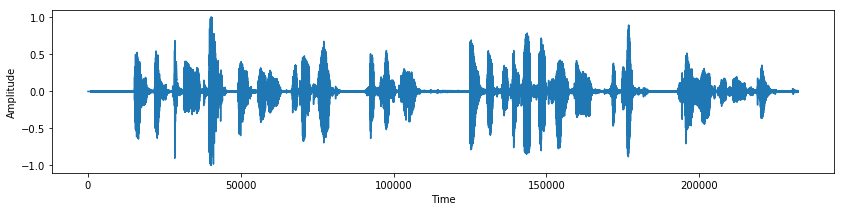

In [58]:
plot_raw_audio(audio_signal)
Audio(path + dst)

##  Extract features and visualize them

#### Mel-Frequency Cepstral Coefficients (MFCCs)
I choose MFCCs features because its popularity in modern Speech Recognition tasks. 
- [1](https://github.com/mozilla/DeepSpeech) uses MFCCs.
- [2](https://github.com/buriburisuri/speech-to-text-wavenet) uses MFCCs.   

I used the following library [python_speech_features](https://github.com/jameslyons/python_speech_features) of the  Python package to extract features.

In [59]:
def plot_mfcc_feature(features):
    fig = plt.figure(figsize=(14,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(features, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized MFCC')
    plt.ylabel('Time')
    plt.xlabel('MFCC Coefficient')
    plt.colorbar(im)
    ax.set_xticks(np.arange(0, 13, 2));
    plt.show()

In [60]:
features_mfcc = librosa.feature.mfcc(audio_signal, 16000, n_mfcc=13)
print('Number of windows =', features_mfcc.shape[0])
print('Length of each feature =', features_mfcc.shape[1])

Number of windows = 13
Length of each feature = 454


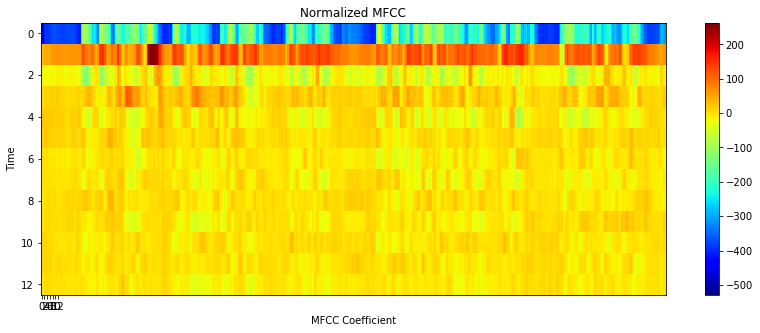

In [61]:
plot_mfcc_feature(features_mfcc)

### Using API

In [62]:
import speech_recognition as sr

In [63]:
r = sr.Recognizer()
harvard = sr.AudioFile(path + dst)
with harvard as source:
    audio = r.record(source)
r.recognize_google(audio, language="de-DE")

'18 fehlt an 7 Implantat Vollkeramikkrone 16 Implantat Vollkeramikkrone verblockt Schleimhautentzündung frei'

### Run pretrained model
I investigated pretrained models for speech recognition. As it turned out there are not many open source one and most of them are for the English language. I used the following [model](https://modeldepot.io/dhruvk/wavenet-speech-to-text#0) for the English language, however, it can be re-trained using [German corpora](https://github.com/ynop/deepspeech-german). Another possible solution which I founded is [Kaldi](http://kaldi-asr.org/) which uses pretrained models for the German language. It can be installed as python package and used as shown [here](https://github.com/gooofy/py-kaldi-asr). 

However, in my personal opinion it is much better to train own model using one of the architectures - [1](https://github.com/mozilla/DeepSpeech) uses MFCCs, [2](https://github.com/buriburisuri/speech-to-text-wavenet) uses MFCCs. It gives flexibility and reliability as benefits.

In [64]:
import sugartensor as tf
from speech_to_text_wavenet.model import *
from speech_to_text_wavenet import data

In [65]:
PRETRAINED_MODEL_LOCATION = path + 'speech_to_text_wavenet/asset/train'

In [66]:
mfcc = np.transpose(np.expand_dims(features_mfcc, axis=0), [0, 2, 1])

In [68]:
batch_size = 1     # batch size
voca_size = data.voca_size

# mfcc feature of audio
x = tf.placeholder(dtype=tf.sg_floatx, shape=(batch_size, None, 20))

# sequence length except zero-padding
seq_len = tf.not_equal(x.sg_sum(axis=2), 0.).sg_int().sg_sum(axis=1)

# encode audio feature
logit = get_logit(x, voca_size=voca_size)

# ctc decoding
decoded, _ = tf.nn.ctc_beam_search_decoder(logit.sg_transpose(perm=[1, 0, 2]), seq_len, merge_repeated=False)

# to dense tensor
y = tf.sparse_to_dense(decoded[0].indices, decoded[0].dense_shape, decoded[0].values) + 1

# run network
with tf.Session() as sess:

    # init variables
    tf.sg_init(sess)

    # restore parameters
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint(PRETRAINED_MODEL_LOCATION))
    # run session
    label = sess.run(y, feed_dict={x: mfcc})

    # print label
    data.print_index(label)

'and upfield and see me implant at 4, corner and sex implant out for, corner for blocked slime hard and son on Sky'

### Research
I did a little research of possible ways to solve Speech recognition problem. It is summarised in the file`research.pdf`  in the root directory

### Resources which were used
- [tutorial point article](https://www.tutorialspoint.com/artificial_intelligence_with_python/artificial_intelligence_with_python_speech_recognition.htm)